In [1]:
%cd ..

/home/clement/Dropbox/MVA/Graphs in ML/project/graphConvNet


# Learning a GNN over MNIST

In this notebook, we are going to learn a classifier over the mnist data. We have purposely used non approximated localized layers (no Chebyshev Recursive formulation), and Transition Matrix based max pooling, to allow interpretation of results over graphical structures. Performances in terms of computational costs, are therefore, not optimals, and could be improved by Lanczos or Chebyshev approximated filters, and 1D Max Pooling on sorted indexes.

The structure will be the following one:

1. Graph Conv Stack
    + Graphical Convolution, with size of neighbourhood 5 and 5 filters
    + Relu non linearity
    + Graphical Max Pooling 
2. Graph Conv Stack
    + Graphical Convolution, with size of neighbourhood 5 and 10 filters
    + Relu non linearity
    + Graphical Max Pooling
3. Graph Conv Stack
    + Graphical Convolution, with size of neighbourhood 5 and 20 filters
    + Relu non linearity
    + Graphical Max Pooling
4. Graph Conv Stack
    + Graphical Convolution, with size of neighbourhood 5 and 40 filters
    + Relu non linearity
    + Graphical Max Pooling
5. Fully connected layer with 100 units
6. Output softmax layer with 10 units

## Experiment


In [3]:
# Imports
import sys, os
sys.path.insert(0,os.getcwd())
import pygsp
import numpy
import tensorflow as tf
import scipy.misc
import matplotlib.pyplot as plt
import scipy.signal
from src.mnist import load_mnist
from src.coarsening import computeCoarsening, computeCoarsenedCoords
import random

numpy.set_printoptions(threshold=numpy.nan)
from IPython.display import clear_output
%matplotlib inline

We are going to use MNIST dataset, with standardization in [0;1] as only pre processing. 

In [4]:
# Load mnist dataset
training_mnist = load_mnist(dataset='training')
testing_mnist = load_mnist(dataset='testing')

training_data = numpy.reshape(training_mnist[0], [training_mnist[0].shape[0],28*28])
training_data = training_data/255.0
training_labels = training_mnist[1]
training_cats = numpy.zeros([training_labels.shape[0], 10])
for i in range(0,training_labels.shape[0]):
    training_cats[i][training_labels[i]]=1
    
testing_data = numpy.reshape(testing_mnist[0], [testing_mnist[0].shape[0],28*28])
testing_data = testing_data/255.0
testing_labels = testing_mnist[1]
testing_cats = numpy.zeros([testing_labels.shape[0], 10])
for i in range(0,testing_labels.shape[0]):
    testing_cats[i][testing_labels[i]]=1

We will use a grid graph as structure for our image signal. We can plot a sample on this grid:

Plotting 4 sample from training data


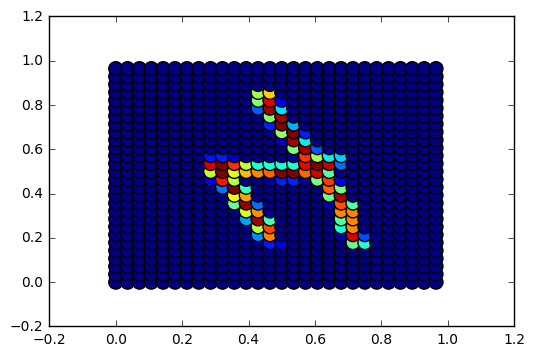

In [5]:
# Create graph grid
gsz = 28
g1 = pygsp.graphs.Grid2d(gsz)

# Plot random sample on the grid
idx = random.randint(0, training_mnist[0].shape[0])
sample = training_data[idx]
print("Plotting %i sample from training data"%training_labels[idx])
pygsp.plotting.plot_signal(g1, sample)

Now we have to compute coarsened graphs Weight and Transition matrices. Those will be useful to compute the max pooling in our cnn. We also create graphs object with nodes coordinates equals to the mean of parents coordinates. This will allows us to plot filtered and pooled signals on understandable structures.

In [6]:
# Coarsen graph

# Level 1
W2, T12 = computeCoarsening(g1.W.todense())
g2 = pygsp.graphs.Graph(W2)
g2.coords = computeCoarsenedCoords(g1.coords,T12)

# Level 2
W3, T23 = computeCoarsening(g2.W.todense())
g3 = pygsp.graphs.Graph(W3)
g3.coords = computeCoarsenedCoords(g2.coords,T23)

# Level 3
W4, T34 = computeCoarsening(g3.W.todense())
g4 = pygsp.graphs.Graph(W4)
g4.coords = computeCoarsenedCoords(g3.coords,T34)

# Level 4
W5, T45 = computeCoarsening(g4.W.todense())
g5 = pygsp.graphs.Graph(W5)
g5.coords = computeCoarsenedCoords(g4.coords,T45)

We compute normalized laplacians that will be used for filtering.

In [7]:
# Compute the normalized laplacians

g1.create_laplacian(lap_type='normalized')
g1.compute_fourier_basis(force_recompute=True)
L1n = (2/g1.lmax)*g1.L.todense() - numpy.eye(g1.L.shape[0])
dim1 = L1n.shape[0]

g2.create_laplacian(lap_type='normalized')
g2.compute_fourier_basis(force_recompute=True)
L2n = (2/g2.lmax)*g2.L.todense() - numpy.eye(g2.L.shape[0])
dim2 = L2n.shape[0]

g3.create_laplacian(lap_type='normalized')
g3.compute_fourier_basis(force_recompute=True)
L3n = (2/g3.lmax)*g3.L.todense() - numpy.eye(g3.L.shape[0])
dim3 = L3n.shape[0]

g4.create_laplacian(lap_type='normalized')
g4.compute_fourier_basis(force_recompute=True)
L4n = (2/g4.lmax)*g4.L.todense() - numpy.eye(g4.L.shape[0])
dim4 = L4n.shape[0]

g5.create_laplacian(lap_type='normalized')
g5.compute_fourier_basis(force_recompute=True)
L5n = (2/g5.lmax)*g5.L.todense() - numpy.eye(g5.L.shape[0])
dim5 = L5n.shape[0]

We instantiate a tensorflow session and define the computation graph.

In [8]:
# We instantiate Session object
sess = tf.InteractiveSession()

## Input ## --------------------------------------------------------------------------------------------------
x = tf.placeholder(tf.float32, shape=[None,dim1])              # x    : [None, dim1]
xc = tf.expand_dims(x, 1)                                      # xc   : [None, 1, dim1] channeled representation
n0 = 1                                                         # number of input channels

## GConv1 ## -------------------------------------------------------------------------------------------------
k1 = 5                                                         # Max neighbour distance for filters  
n1 = 5                                                         # Number of filters
n1i = n0                                                       # Number of input channels
e1 = numpy.ndarray([k1, g1.e.shape [0]])
# Load power of \Lambda
for i in range(0,k1):
    e1[i] = numpy.power(g1.e,i)
# Declare Layer variables and constants
eig1 = tf.constant(e1, dtype=tf.float32)                       # eig1 : [k1, dim1]
U1 = tf.constant(g1.U, dtype=tf.float32)                       # U1   : [dim1, dim1]
W1 = tf.Variable(tf.truncated_normal([n1, k1], stddev=0.1))    # W1   : [n1, k1]
b1 = tf.Variable(tf.constant(0.1, shape=[n1]))                 # b1   : [n1]
# We put into Fourier Basis
x1f = tf.reshape(xc, [-1, dim1])                               # x1f  : [None*n1i, dim1]
x1f = tf.matmul(U1,x1f,transpose_a=True, transpose_b=True)     # x1f  : [dim1, None*n1i]
x1f = tf.reshape(tf.transpose(x1f),[-1, n1i, dim1])            # x1f  : [None, n1i, dim1]
# We compute filters
f1f = tf.expand_dims(tf.transpose(W1),1)                       # f1f  : [k1, 1, n1]
f1f = tf.mul(tf.expand_dims(eig1,2), f1f)                      # f1f  : [k1, dim1, n1]
f1f = tf.reduce_sum(f1f,axis=0)                                # f1f  : [dim1, n1]
f1f = tf.add(tf.expand_dims(b1,0), f1f)                        # f1f  : [dim1, n1]
f1f = tf.expand_dims(tf.transpose(f1f), 0)                     # f1f  : [1, n1, dim1]
# We filter the signal
x1f = tf.expand_dims(x1f,1)                                    # x1f  : [None, 1, n1i, dim1]
f1f = tf.expand_dims(f1f,2)                                    # f1f  : [1, n1, 1, dim1]
y1f = tf.mul(x1f,f1f)                                          # y1f  : [None, n1, n1i, dim1]
y1f = tf.reshape(y1f, [-1, n1*n1i, dim1])                      # y1f  : [None, n1*n1i, dim1]
y1f = tf.transpose(y1f)                                        # y1f  : [dim1, n1*n1i, None]
# We move back to the normal basis
y1 = tf.reshape(y1f, [dim1,-1])                                # y1   : [dim1, None*n1*n1i]
y1 = tf.batch_matmul(U1,y1)                                    # y1   : [dim1, None*n1*n1i]
y1 = tf.reshape(y1, [dim1,n1*n1i,-1])                          # y1   : [dim1, n1*n1i, None]
y1 = tf.transpose(y1)                                          # y1   : [None, n1*n1i, dim1]

## Squash1 ## -----------------------------------------------------------------------------------------------
y1 = tf.nn.relu(y1)                                            # y1   : [None, n1*n1i, dim1]

## GPool1 ## ------------------------------------------------------------------------------------------------
TR12 = tf.constant(T12, dtype=tf.float32)                      # TR12 : [dim2, dim1]
y1p = tf.transpose(y1)                                         # y1p  : [dim1, n1*n1i, None]
y1p = tf.reshape(y1p, [dim1, -1])                              # y1p  : [dim1, n1*n1i*None]
y1p = tf.expand_dims(y1p, 0)                                   # y1p  : [1, dim1, n1*n1i*None]
y1p = tf.mul(tf.expand_dims(TR12, 2),y1p)                      # y1p  : [dim2, dim1, n1*n1i*None]
y1p = tf.reduce_max(y1p, axis=1)                               # y1p  : [dim2, n1*n1i*None]
y1p = tf.reshape(y1p, [TR12.get_shape()[0].value, n1*n1i, -1]) # y1p  : [dim2, n1*n1i, None]
y1p = tf.transpose(y1p)                                        # y1p  : [None, n1*n1i, dim2]

## GConv2 ## -------------------------------------------------------------------------------------------------
k2 = 5                              
n2 = 2
n2i = n1*n1i 
e2 = numpy.ndarray([k2, g2.e.shape[0]])
# Load power of \Lambda
for i in range(0,k2):
    e2[i] = numpy.power(g2.e,i)
# Declare Layer variables and constants
eig2 = tf.constant(e2, dtype=tf.float32)
U2 = tf.constant(g2.U, dtype=tf.float32)
W2 = tf.Variable(tf.truncated_normal([n2, k2], stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape=[n2]))
# We put into Fourier Basis
x2f = tf.reshape(y1p, [-1, dim2])
x2f = tf.matmul(U2,x2f,transpose_a=True, transpose_b=True)
x2f = tf.reshape(tf.transpose(x2f),[-1, n2i, dim2])
# We compute filters
f2f = tf.expand_dims(tf.transpose(W2),1)
f2f = tf.mul(tf.expand_dims(eig2,2), f2f)
f2f = tf.reduce_sum(f2f,axis=0)
f2f = tf.add(tf.expand_dims(b2,0), f2f)
f2f = tf.expand_dims(tf.transpose(f2f), 0)
# We filter the signal           
x2f = tf.expand_dims(x2f,1)
f2f = tf.expand_dims(f2f,2)
y2f = tf.mul(x2f,f2f)
y2f = tf.reshape(y2f, [-1, n2*n2i, dim2])
y2f = tf.transpose(y2f)
# We move back to the normal basis
y2 = tf.reshape(y2f, [dim2,-1])
y2 = tf.batch_matmul(U2,y2)
y2 = tf.reshape(y2, [dim2,n2*n2i,-1])
y2 = tf.transpose(y2)

## Squash2 ## -----------------------------------------------------------------------------------------------
y2 = tf.nn.relu(y2)

## GPool2 ## ------------------------------------------------------------------------------------------------
TR23 = tf.constant(T23, dtype=tf.float32)
y2p = tf.transpose(y2)
y2p = tf.reshape(y2p, [dim2, -1])
y2p = tf.expand_dims(y2p, 0)
y2p = tf.mul(tf.expand_dims(TR23, 2),y2p)
y2p = tf.reduce_max(y2p, axis=1)
y2p = tf.reshape(y2p, [TR23.get_shape()[0].value, n2*n2i, -1])
y2p = tf.transpose(y2p)

## GConv3 ## -------------------------------------------------------------------------------------------------
k3 = 5
n3 = 2 
n3i = n2*n2i
e3 = numpy.ndarray([k3, g3.e.shape[0]])
# Load power of \Lambda
for i in range(0,k3):
    e3[i] = numpy.power(g3.e,i)
# Declare Layer variables and constants
eig3 = tf.constant(e3, dtype=tf.float32)
U3 = tf.constant(g3.U, dtype=tf.float32)
W3 = tf.Variable(tf.truncated_normal([n3, k3], stddev=0.1))
b3 = tf.Variable(tf.constant(0.1, shape=[n3]))
# We put into Fourier Basis
x3f = tf.reshape(y2p, [-1, dim3])
x3f = tf.matmul(U3,x3f,transpose_a=True, transpose_b=True)
x3f = tf.reshape(tf.transpose(x3f),[-1, n2, dim3])
# We compute filters
f3f = tf.expand_dims(tf.transpose(W3),1)
f3f = tf.mul(tf.expand_dims(eig3,2), f3f)
f3f = tf.reduce_sum(f3f,axis=0)
f3f = tf.add(tf.expand_dims(b3,0), f3f)
f3f = tf.expand_dims(tf.transpose(f3f), 0)
# We filter the signal                         
x3f = tf.expand_dims(x3f,1)
f3f = tf.expand_dims(f3f,2)
y3f = tf.mul(x3f,f3f)
y3f = tf.reshape(y3f, [-1, n3*n3i, dim3])
y3f = tf.transpose(y3f)
# We move back to the normal basis
y3 = tf.reshape(y3f, [dim3,-1])
y3 = tf.batch_matmul(U3,y3)
y3 = tf.reshape(y3, [dim3,n3*n3i,-1])
y3 = tf.transpose(y3)

## Squash3 ## -----------------------------------------------------------------------------------------------
y3 = tf.nn.relu(y3)

## GPool3 ## ------------------------------------------------------------------------------------------------
TR34 = tf.constant(T34, dtype=tf.float32)
y3p = tf.transpose(y3)
y3p = tf.reshape(y3p, [dim3, -1])
y3p = tf.expand_dims(y3p, 0)
y3p = tf.mul(tf.expand_dims(TR34, 2),y3p)
y3p = tf.reduce_max(y3p, axis=1)
y3p = tf.reshape(y3p, [TR34.get_shape()[0].value, n3*n3i, -1])
y3p = tf.transpose(y3p)

## GConv4 ## -------------------------------------------------------------------------------------------------
k4 = 5
n4 = 2
n4i = n3*n3i
e4 = numpy.ndarray([k4, g4.e.shape[0]])
# Load power of \Lambda
for i in range(0,k4):
    e4[i] = numpy.power(g4.e,i)
# Declare Layer variables and constants
eig4 = tf.constant(e4, dtype=tf.float32)
U4 = tf.constant(g4.U, dtype=tf.float32)
W4 = tf.Variable(tf.truncated_normal([n4, k4], stddev=0.1))
b4 = tf.Variable(tf.constant(0.1, shape=[n4]))
# We put into Fourier Basis
x4f = tf.reshape(y3p, [-1, dim4])
x4f = tf.matmul(U4,x4f,transpose_a=True, transpose_b=True)
x4f = tf.reshape(tf.transpose(x4f),[-1, n3, dim4])
# We compute filters
f4f = tf.expand_dims(tf.transpose(W4),1)
f4f = tf.mul(tf.expand_dims(eig4,2), f4f)
f4f = tf.reduce_sum(f4f,axis=0)
f4f = tf.add(tf.expand_dims(b4,0), f4f)
f4f = tf.expand_dims(tf.transpose(f4f), 0)
# We filter the signal                         
x4f = tf.expand_dims(x4f,1)
f4f = tf.expand_dims(f4f,2)
y4f = tf.mul(x4f,f4f)
y4f = tf.reshape(y4f, [-1, n4*n4i, dim4])
y4f = tf.transpose(y4f)
# We move back to the normal basis
y4 = tf.reshape(y4f, [dim4,-1])
y4 = tf.batch_matmul(U4,y4)
y4 = tf.reshape(y4, [dim4,n4*n4i,-1])
y4 = tf.transpose(y4)

## Squash4 ## -----------------------------------------------------------------------------------------------
y4 = tf.nn.relu(y4)

## GPool4 ## ------------------------------------------------------------------------------------------------
TR45 = tf.constant(T45, dtype=tf.float32)
y4p = tf.transpose(y4)
y4p = tf.reshape(y4p, [dim4, -1])
y4p = tf.expand_dims(y4p, 0)
y4p = tf.mul(tf.expand_dims(TR45, 2),y4p)
y4p = tf.reduce_max(y4p, axis=1)
y4p = tf.reshape(y4p, [TR45.get_shape()[0].value, n4*n4i, -1])
y4p = tf.transpose(y4p)

## FC5 ## ---------------------------------------------------------------------------------------------------
n5 = 100
# Declare layer variables
W5 = tf.Variable(tf.truncated_normal([n4*n4i*dim5, n5], stddev=0.1))
b5 = tf.Variable(tf.constant(0.1, shape=[n5]))
# We compute the filtered signals
y5 = tf.reshape(y4p, [-1, n4*n4i*dim5])
y5 = tf.nn.relu(tf.matmul(y5, W5) + b5)

## FC6 ## ---------------------------------------------------------------------------------------------------
n6 = 10
# Declare layer variables
W6 = tf.Variable(tf.truncated_normal([n5, n6], stddev=0.1))
b6 = tf.Variable(tf.constant(0.1, shape=[n6]))
# We compute the filtered signal
y6 = tf.matmul(y5, W6) + b6

## SM ## ----------------------------------------------------------------------------------------------------
ygcnn = tf.nn.softmax(y6)
y = tf.placeholder(tf.float32, shape=[None, n6])

To verify that a signal is pooled according to our intuition, we plot pooled signals on coarsened graphs for fixed filters.

Plotting signal conved 0 time, output is of shape: (2, 5, 428)


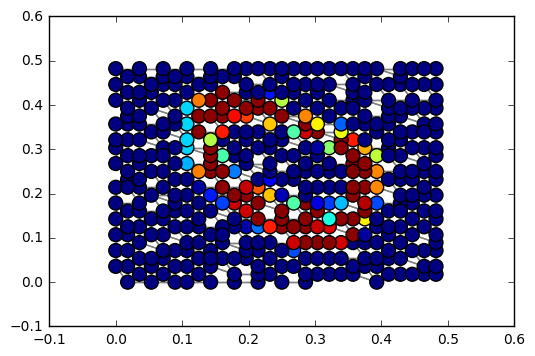

Plotting signal conved 1 time, output is of shape: (2, 10, 233)


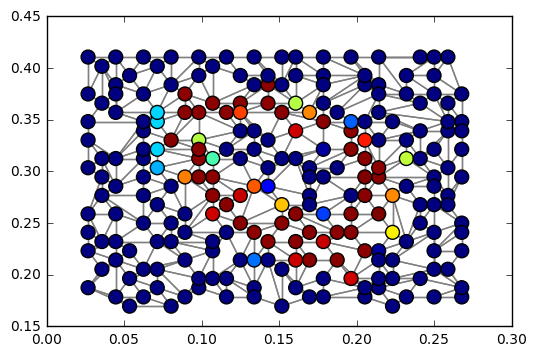

Plotting signal conved 2 time, output is of shape: (2, 20, 125)


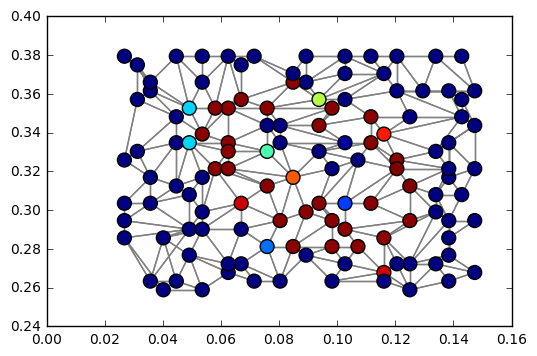

Plotting signal conved 3 time, output is of shape: (2, 40, 70)


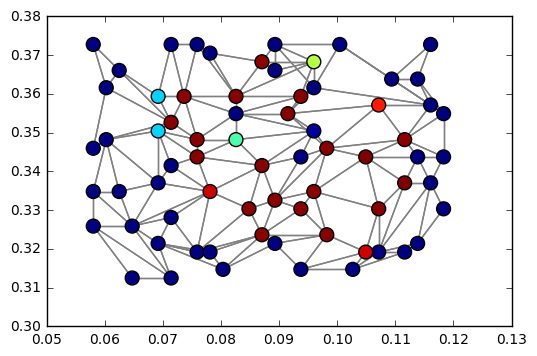

In [9]:
# Check if things are working expectedly
sample = training_data[1:3]

# Initialize variables
sess.run(tf.global_variables_initializer())

W = numpy.array([[0,0,0,0,1],[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0]])
b = numpy.array([0,0,0,0,0])

ys = [y1p, y2p, y3p, y4p]
g = [g1, g2, g3, g4, g5]
fd={x : sample, W1:W, W2:W[1:3], W3:W[1:3], W4:W[1:3], b1:b, b2:b[1:3], b3:b[1:3], b4:b[1:3]}
l = [ysi.eval(feed_dict = fd) for ysi in ys]

for i in range(4):
    print("Plotting signal conved %i time, output is of shape: %s"%(i,str(l[i].shape)))
    pygsp.plotting.plot_signal(g[i+1],l[i][0][1])
    plt.show()

Plotting signal conved 0 time, output is of shape: (2, 5, 428)
Plotting signal conved 1 time, output is of shape: (2, 10, 233)
Plotting signal conved 2 time, output is of shape: (2, 20, 125)
Plotting signal conved 3 time, output is of shape: (2, 40, 70)


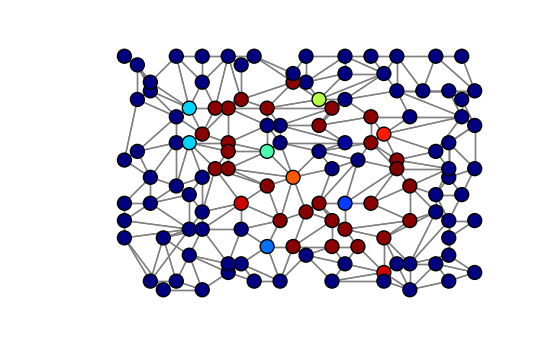

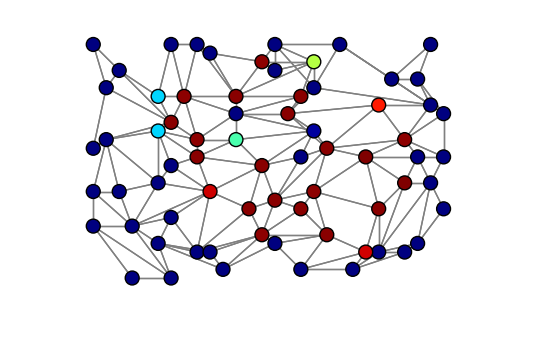

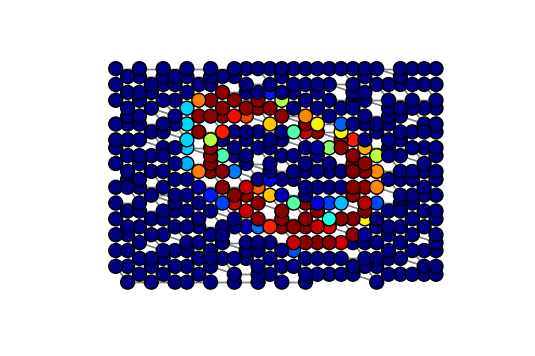

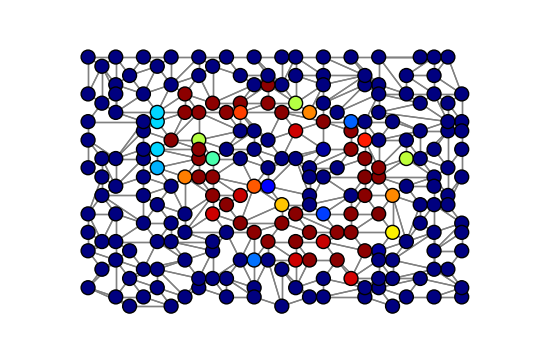

In [10]:
for i in range(4):
    print("Plotting signal conved %i time, output is of shape: %s"%(i,str(l[i].shape)))
    pygsp.plotting.plot_signal(g[i+1],l[i][0][1])
    plt.axis('off')
    plt.savefig("coarsening_{}.pdf".format(i), bbox_inches='tight')

We define the loss.

In [11]:
# Define Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y * tf.log(ygcnn), reduction_indices=[1]))
weights   = tf.trainable_variables() 
weights_decay = tf.add_n([tf.nn.l2_loss(v) for v in weights])*0.001
loss = tf.add(cross_entropy, weights_decay)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
correct_prediction = tf.equal(tf.argmax(ygcnn,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

And then, we train the network.

step 9900, training accuracy 0.93, testing accuracy 0.95


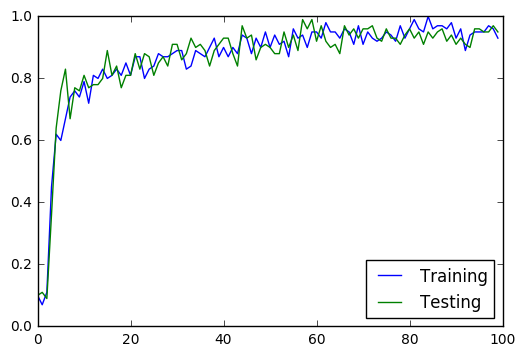

In [9]:
# We initialize the values
sess.run(tf.global_variables_initializer())
hist = numpy.ones([100,2])*numpy.nan

# Train
for i in range(10000):
    idx = numpy.random.permutation(training_data.shape[0])
    idx = idx[0:100]
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:training_data[idx], y: training_cats[idx]})
        idx = numpy.random.permutation(testing_data.shape[0])
        idx = idx[0:100]
        test_accuracy = accuracy.eval(feed_dict={x:testing_data[idx], y:testing_cats[idx]})
        hist[i/100][0] = train_accuracy
        hist[i/100][1] = test_accuracy
        clear_output()
        print("step %d, training accuracy %g, testing accuracy %g"%(i, train_accuracy, test_accuracy))
        plt.plot(hist[:,0], label="Training")
        plt.plot(hist[:,1], label="Testing")
        plt.legend(loc=4)
        plt.show()
    train_step.run(feed_dict={x: training_data[idx] , y: training_cats[idx]})